# The Julia Sets and The Mandelbrot Set

As we know already, the Mandelbrot set is the set of points in the complex plane that satisfies the following definition:
For a given complex value of c, start with z = 0 and iterate repeatedly. If the magnitude |z| of the resulting value is ever greater than 2, then the point in the complex plane at position c is not in the Mandelbrot set, otherwise it is in the set.

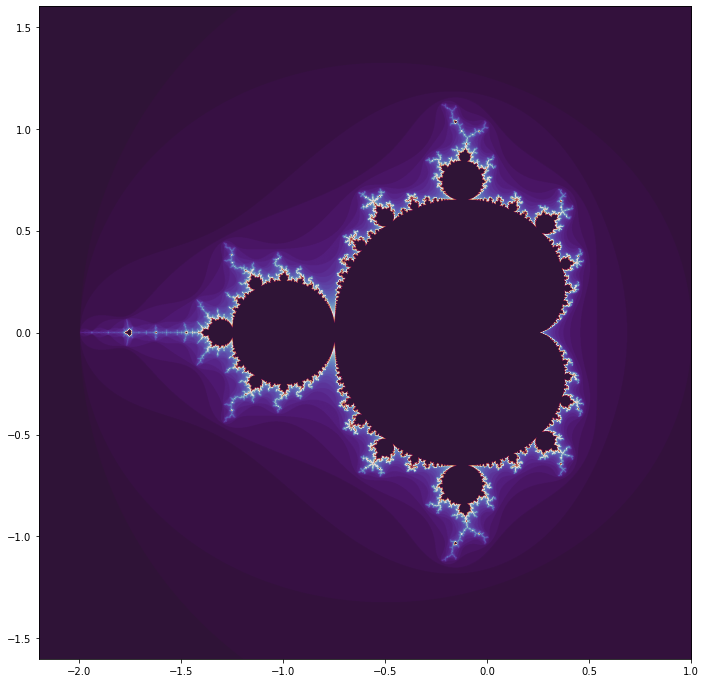

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

def mandelbrot_set(h_range, w_range, max_iterations):
    y, x = np.ogrid[1.6: -1.6: h_range*1j, -2.2: 1: w_range*1j]
    a_array = x + y*1j
    z_array = np.zeros(a_array.shape) 
    iterations_till_divergence = max_iterations + np.zeros(a_array.shape)

    # make an array with all elements set to 'True'
    not_already_diverged = a_array < 1000
    
    for i in range(max_iterations):
        # mandelbrot equation
        z_array = z_array**2 + a_array 

        # make a boolean array for diverging indicies of z_array
        z_size_array = z_array * np.conj(z_array)
        divergent_array = z_size_array > 4
        diverging_now = divergent_array & not_already_diverged

        iterations_till_divergence[diverging_now] = i
        # prevent overflow (numbers -> infinity) for diverging locations
        z_array[divergent_array] = 0

        # prevent the a point from diverging again in future iterations
        not_already_diverged = np.invert(diverging_now) & not_already_diverged
    return iterations_till_divergence

plt.figure(figsize=(12, 12))
plt.imshow(mandelbrot_set(2000, 2000, 70), cmap='twilight_shifted', extent=[-2.2, 1, -1.6, 1.6])
plt.axis('on')
plt.show()

In contrast to the Mandelbrot set, Julia sets change the value of z while keeping c constant.

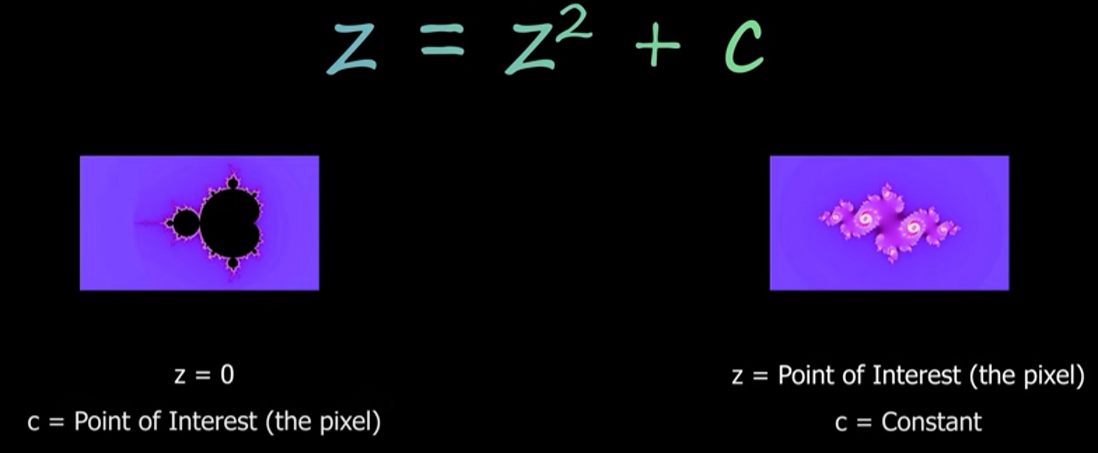

This means that each value of c generates a unique Julia set.

https://en.wikipedia.org/wiki/Julia_set#/media/File:JSr07885.gif

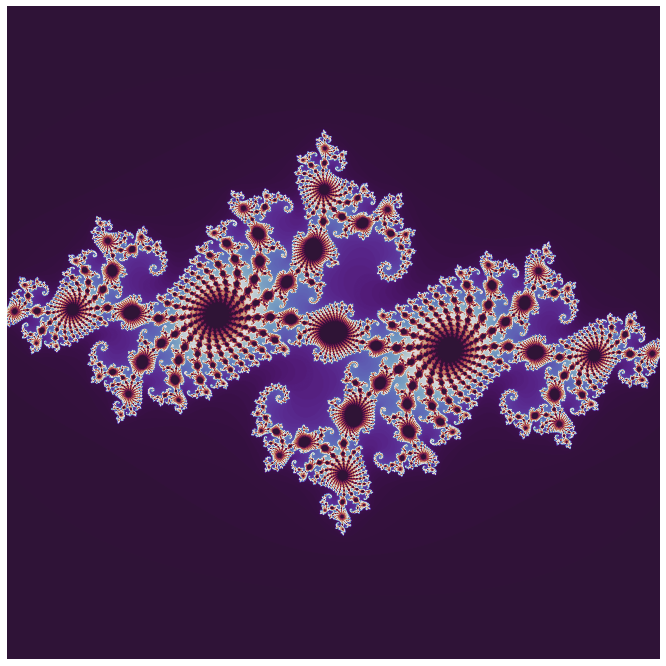

In [2]:
def julia_set(h_range, w_range, max_iterations, a):
    ''' A function to determine the values of the Julia set. Takes
    an array size specified by h_range and w_range, in pixels, along
    with the number of maximum iterations to try.  Returns an array with 
    the number of the last bounded iteration at each array value.
    '''
    # top left to bottom right
    y, x = np.ogrid[1.4: -1.4: h_range*1j, -1.4: 1.4: w_range*1j]
    z_array = x + y*1j
    iterations_until_divergence = max_iterations + np.zeros(z_array.shape)

    # create array of all True
    not_already_diverged = iterations_until_divergence < 10000

    # creat array of all False
    diverged_in_past = iterations_until_divergence > 10000
    iterations_till_divergence = max_iterations + np.zeros(z_array.shape)
    for i in range(max_iterations):
        z_array = z_array**2 + a
        z_size_array = z_array * np.conj(z_array)
        diverging = z_size_array > 4

        diverging_now = diverging & not_already_diverged
        iterations_till_divergence[diverging_now] = i

        not_already_diverged = np.invert(diverging_now) & not_already_diverged
        # prevent overflow (values headed towards infinity) for diverging locations
        diverged_in_past = diverged_in_past | diverging_now
        z_array[diverged_in_past] = 0

    return iterations_till_divergence
plt.figure(figsize=(12, 12))
plt.imshow(julia_set(2000, 2000, 200, -0.744 + 0.148j), cmap='twilight_shifted', extent=[-1.4, 1.4, -1.4, 1.4])
plt.axis('off')
plt.show()
plt.close()

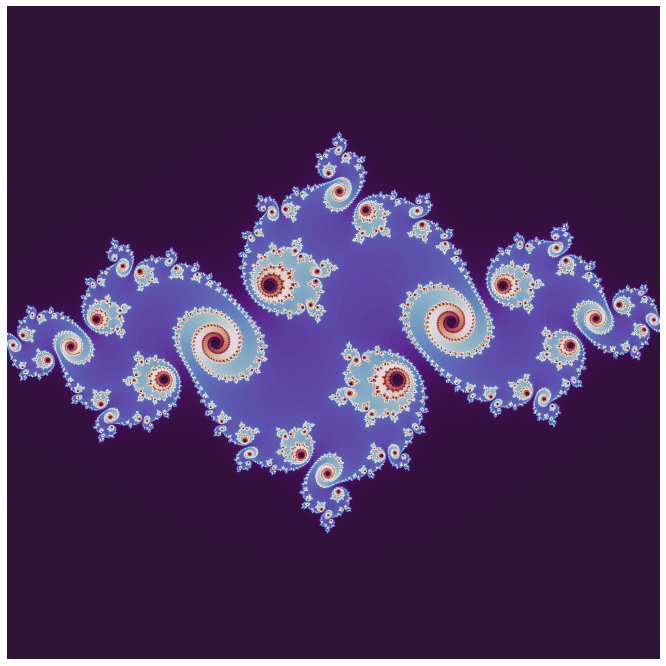

In [3]:
plt.figure(figsize=(12, 12))
plt.imshow(julia_set(2000, 2000, 200, -0.76-0.09j), cmap='twilight_shifted', extent=[-1.4, 1.4, -1.4, 1.4])
plt.axis('off')
plt.show()
plt.close()

Amongst the two Julia sets above it is important to distinguish the differece between the kinds of Julia sets as well as establishing what part of the image is the Julia set. The large black circular areas are what is known as filled Julia sets but it must be noted that the actual Julia sets itself does not include these areas but rather only the edges of them. 

Regarding the types of Julia sets, the first set is a connected Julia set, all components can be seen connected to each other, while the second set is what is referred to as "dust" because it is composed of infinitely many small pieces that do not connect.

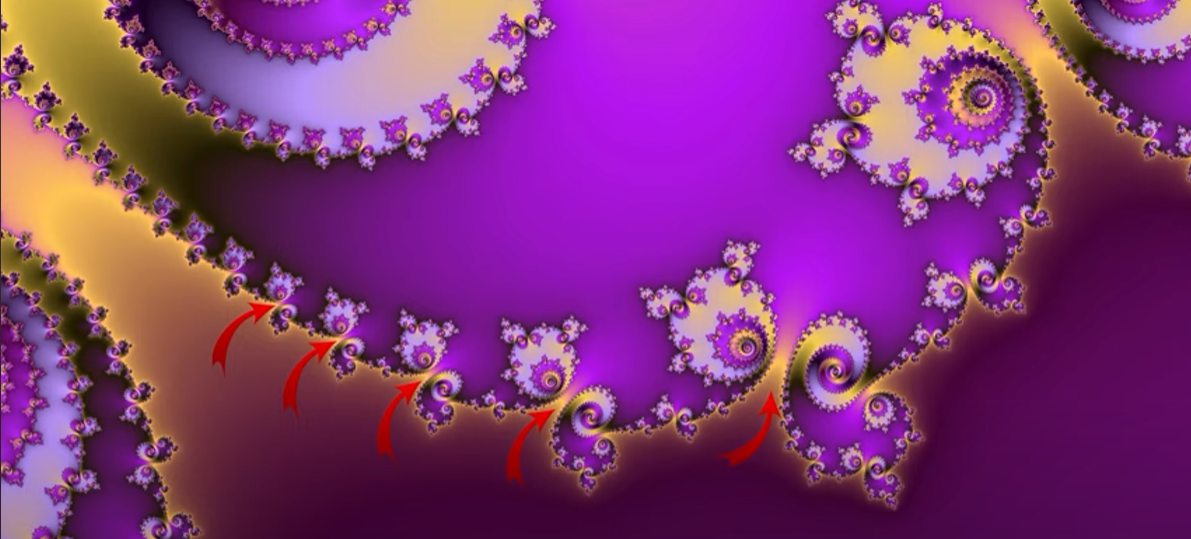

This property can be seen above as this dust Julia set never connects at any point. It must be stated that all Julia sets are either entirely connected or entirely dust, there are no sets composed of few large pieces.

The connection between the Julia sets and the Mandelbrot set is that the Mandelbrot set is actually a map of all the connected Julia sets. It can be easier to imagine the Mandelbrot set as a grid where each point on the grid has a unique Julia set, those of which that are inside the Mandelbrot set are connected while those outisde the set are dust.

As illistrated by https://jenerator.herokuapp.com/

To emphasize this point, if every julia set were mapped with its center at its point on the complex plane the result would be photograpic mosaic of the Mandrelbrot set
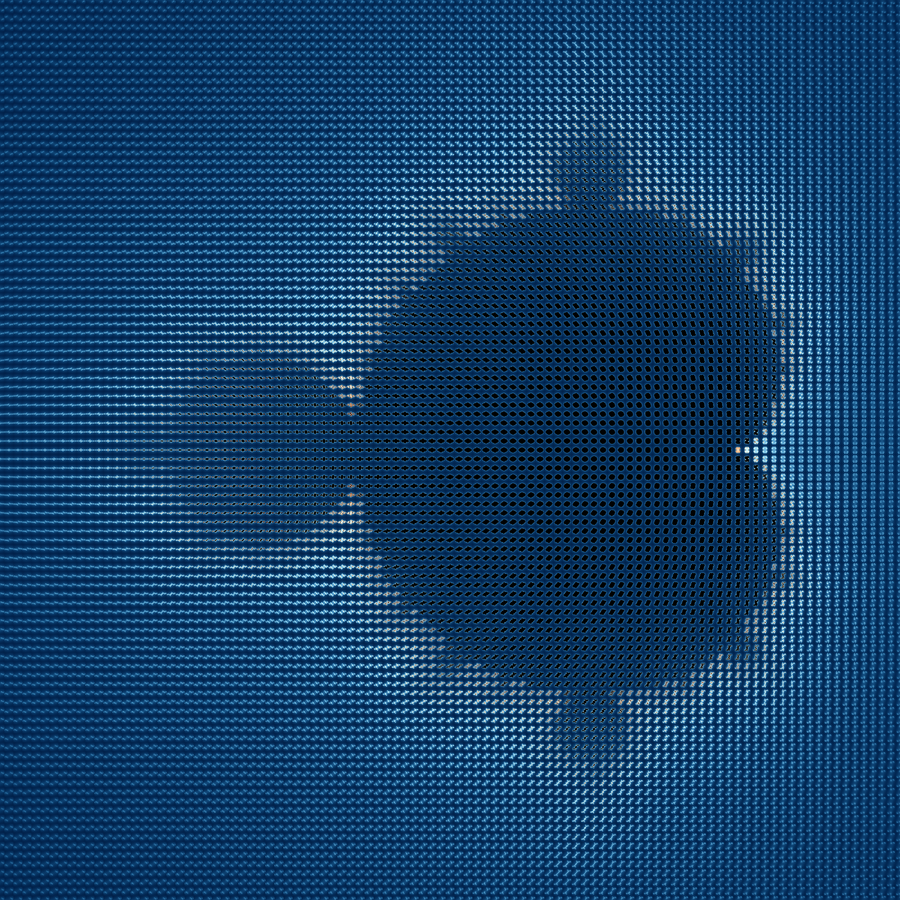

When analysing the Mandelbrot set, many Julia sets can actually be found when zoomed in on on the outer edges of the Mandelbrot set, these are known as embedded Julia sets. Within these embedded Julia sets even more Mandelbrot sets can be found in their centers.

In [ ]:
from __future__ import division
import pygame
from pygame.locals import *

from OpenGL.GL import *
from OpenGL.GL import shaders
#from OpenGL.GLU import *

from sys import exit as exitsystem

from numpy import array, count_nonzero


WIDTH, HEIGHT = 1920, 1080

zoomOut = 1.011
zoomIn = 0.989
movementSpeed = 0.002

def ReadFile(filename):
    data = ""
    with open(filename, 'r') as f:
        data = f.read()
    return data

VERTEX_SHADER = ReadFile('./vertexShader.glsl')
FRAGMENT_SHADER = ReadFile('./fragmentShader.glsl')


class Main(object):
    def __init__(self):
        pygame.init()
        self.resolution = WIDTH, HEIGHT
        pygame.display.set_mode(self.resolution, DOUBLEBUF | OPENGL)
        pygame.display.set_caption('PyShadeToy')

        # Shaders
        self.vertex_shader = shaders.compileShader(VERTEX_SHADER, GL_VERTEX_SHADER)
        self.fragment_shader = shaders.compileShader(FRAGMENT_SHADER, GL_FRAGMENT_SHADER)

        # Shader program which hosts the vertex and fragment shader
        self.shader = shaders.compileProgram(self.vertex_shader, self.fragment_shader)

        # Get the uniform locations
        self.uni_mouse = glGetUniformLocation(self.shader, 'iMouse')
        self.uni_ticks = glGetUniformLocation(self.shader, 'iTime')

        glUseProgram(self.shader)   # Need to be enabled before sending uniform variables
        # Resolution doesn't change. Send it once
        glUniform2f(glGetUniformLocation(self.shader, 'iResolution'), *self.resolution)

        # Create the fullscreen quad for drawing
        self.vertices = array([-1.0, -1.0, 0.0,
                                1.0, -1.0, 0.0,
                                1.0,  1.0, 0.0,
                                -1.0, 1.0, 0.0
                               ], dtype='float32')

        # Generate VAO
        self.vao = glGenVertexArrays(1)
        glBindVertexArray(self.vao)

        # Generate VBO which is stored in the VAO state
        self.vbo = glGenBuffers(1)
        glBindBuffer(GL_ARRAY_BUFFER, self.vbo)
        glBufferData(GL_ARRAY_BUFFER, self.vertices, GL_STATIC_DRAW)

        glEnableVertexAttribArray(0)
        glVertexAttribPointer(0, 3, GL_FLOAT, GL_FALSE, 0, None)


        self.clock = pygame.time.Clock()
        self.CenterX = glGetUniformLocation(self.shader, 'CenterX')
        self.CenterY = glGetUniformLocation(self.shader, 'CenterY')
        self.ZoomScale = glGetUniformLocation(self.shader, 'ZoomScale')
        self.ColorRanges = glGetUniformLocation(self.shader, "ColorRanges")
    def mainloop(self):

        x, y, z = 0.0, 0.0, 1.0

        #px_data =[WIDTH * HEIGHT, 0.1]

        cr = (0.0001, 0.33333, 0.66667, 1.00)

        while 1:
            delta = self.clock.tick(8192)

            glClearColor(0.0, 0.0, 0.0, 1.0)
            glClear(GL_COLOR_BUFFER_BIT)

            #Handle Inputs
            keys = pygame.key.get_pressed()
            if keys[pygame.K_UP]:
                y =  y + movementSpeed * z
                if y > 1.0:
                     y = 1.0

            if keys[pygame.K_DOWN]:
                y =  y - movementSpeed * z
                if y < -1.0:
                    y  = -1.0

            if keys[pygame.K_LEFT]:
                x = x - movementSpeed * z
                if x < -1.0:
                    x  = -1.0


            if keys[pygame.K_RIGHT]:
                x = x + movementSpeed * z
                if x > 1.0:
                    x  = 1.0

            if keys[pygame.K_KP_PLUS]:
                z = z * zoomIn
                if z > 1.0:
                    z = 1.0

            if keys[pygame.K_KP_MINUS]:
                z = z * zoomOut
                if z > 1.0:
                    z = 1.0

            for event in pygame.event.get():
                if (event.type == QUIT) or (event.type == KEYUP and event.key == K_ESCAPE):
                    pygame.quit()
                    exitsystem()

                # if event.type == KEYDOWN:
                #
                #     print(f'{x}, {y}, zoom: {z}')
            glUseProgram(self.shader)

            # Send uniform values
            glUniform2f(self.uni_mouse, *pygame.mouse.get_pos())
            glUniform1f(self.uni_ticks, pygame.time.get_ticks() / 1000.0)
            glUniform1f(self.CenterX, x)
            glUniform1f(self.CenterY, y)
            glUniform1f(self.ZoomScale, z)
            glUniform4f(self.ColorRanges, *cr)

            # Bind the vao (which stores the VBO with all the vertices)
            glBindVertexArray(self.vao)
            glDrawArrays(GL_QUADS, 0, 4)

            #data = glReadPixels(0, 0 , WIDTH , HEIGHT , GL_DEPTH_COMPONENT, GL_FLOAT)
            #data = array(data).flatten()
            #
            # print(len(data))
            # print(len(data[0]))
            #cr = ComputeColor(data)

            pygame.display.set_caption("FPS: {}".format(self.clock.get_fps()))
            pygame.display.flip()


if __name__ == '__main__':
    Main().mainloop()


The connections between the Julia sets and the Mandelbrot set becomes very clear when it is stated that Benoit Mandelbrot created the Mandelbrot set when studying the nature of Julia sets.